# Student Exam Score Prediction: End-to-End Regression Pipeline

## Overview
This notebook implements a comprehensive pipeline to predict student exam scores using the StudentPerformanceFactors dataset. We'll build both linear and polynomial regression models, experiment with feature combinations, and follow ML best practices for reproducible results.

**Key Objectives:**
- Develop an efficient end-to-end data analysis pipeline
- Compare linear vs polynomial regression performance
- Experiment with feature selection and combinations
- Use only Python, Pandas, Matplotlib, and Scikit-learn

## 1. Data Loading and Initial Exploration

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [104]:
# Load the dataset
df = pd.read_csv('StudentPerformanceFactors.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable (Exam_Score) statistics:")
print(df['Exam_Score'].describe())

# Display first few rows
df.head()

Dataset shape: (6607, 20)

Target variable (Exam_Score) statistics:
count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: Exam_Score, dtype: float64


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [105]:
# Check data types and missing values
print("Data Info:")
df.info()

print("\nMissing values per column:")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

print(f"\nDuplicate rows: {df.duplicated().sum()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-

## 2. Data Cleaning and Preprocessing

In [106]:
# Handle missing values using mode imputation for categorical features
categorical_cols_with_missing = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

for col in categorical_cols_with_missing:
    if col in df.columns and df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_value}")

# Handle outliers in target variable
print(f"\nExam_Score range before clipping: {df['Exam_Score'].min()} - {df['Exam_Score'].max()}")
df['Exam_Score'] = df['Exam_Score'].clip(upper=100)
print(f"Exam_Score range after clipping: {df['Exam_Score'].min()} - {df['Exam_Score'].max()}")

# Verify no missing values remain
print(f"\nRemaining missing values: {df.isnull().sum().sum()}")

Filled Teacher_Quality missing values with mode: Medium
Filled Parental_Education_Level missing values with mode: High School
Filled Distance_from_Home missing values with mode: Near

Exam_Score range before clipping: 55 - 101
Exam_Score range after clipping: 55 - 100

Remaining missing values: 0


/var/folders/xp/rlk_0dkd7zb5cq08twv_yntm0000gn/T/ipykernel_22391/3943410560.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


## 3. Exploratory Data Analysis (EDA)

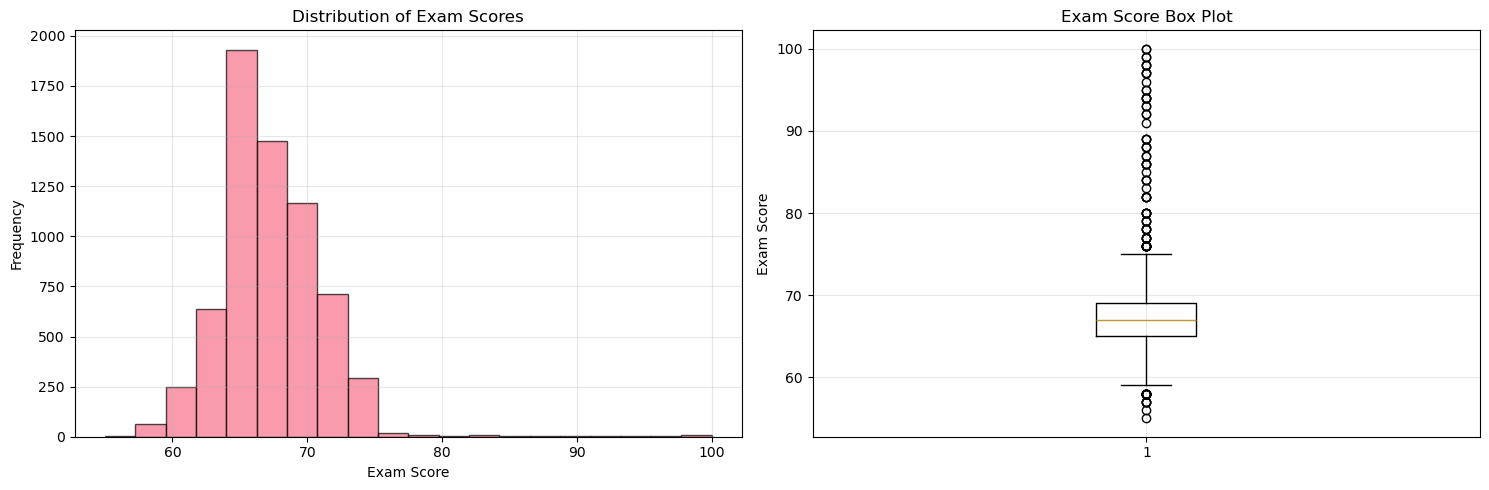

Exam Score - Mean: 67.24, Std: 3.89
Exam Score - Skewness: 1.638


In [107]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['Exam_Score'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Scores')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df['Exam_Score'])
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Exam Score Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Exam Score - Mean: {df['Exam_Score'].mean():.2f}, Std: {df['Exam_Score'].std():.2f}")
print(f"Exam Score - Skewness: {df['Exam_Score'].skew():.3f}")

In [108]:
# Identify numeric and categorical features
numeric_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 
                   'Tutoring_Sessions', 'Physical_Activity']

categorical_features = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                       'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                       'School_Type', 'Peer_Influence', 'Learning_Disabilities',
                       'Parental_Education_Level', 'Distance_from_Home', 'Gender']

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Numeric features (6): ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

Categorical features (13): ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


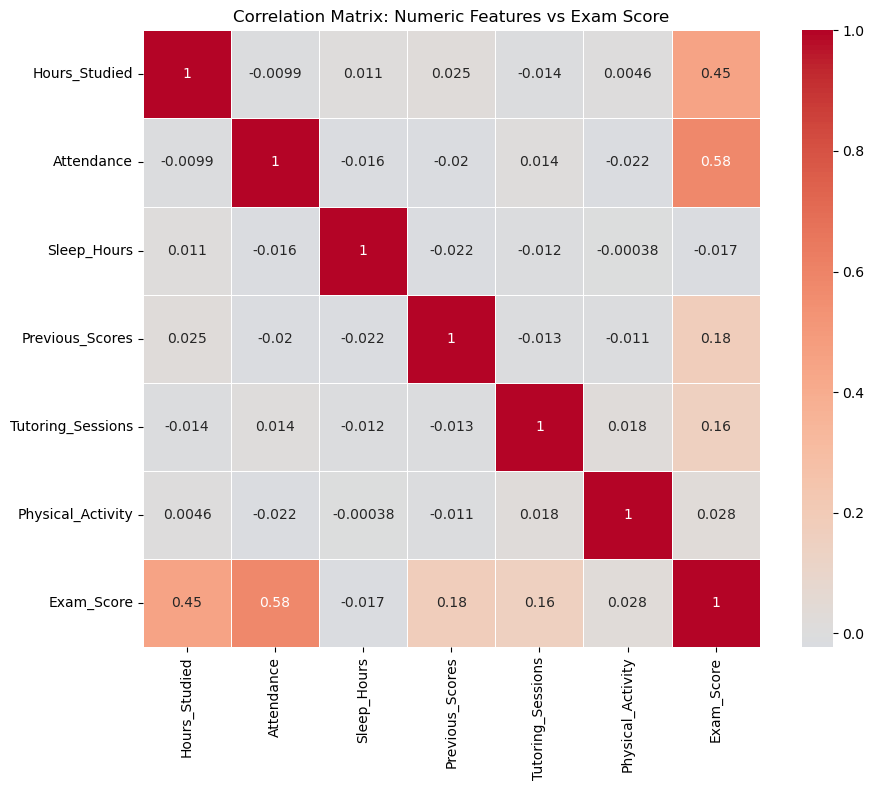


Correlations with Exam_Score (sorted by absolute value):
Attendance          :  0.581
Hours_Studied       :  0.446
Previous_Scores     :  0.175
Tutoring_Sessions   :  0.156
Physical_Activity   :  0.028
Sleep_Hours         : -0.017


In [109]:
# Correlation analysis for numeric features
numeric_data = df[numeric_features + ['Exam_Score']]
correlation_matrix = numeric_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Numeric Features vs Exam Score')
plt.tight_layout()
plt.show()

# Display correlations with target variable
target_correlations = correlation_matrix['Exam_Score'].drop('Exam_Score').sort_values(key=abs, ascending=False)
print("\nCorrelations with Exam_Score (sorted by absolute value):")
for feature, corr in target_correlations.items():
    print(f"{feature:20}: {corr:6.3f}")

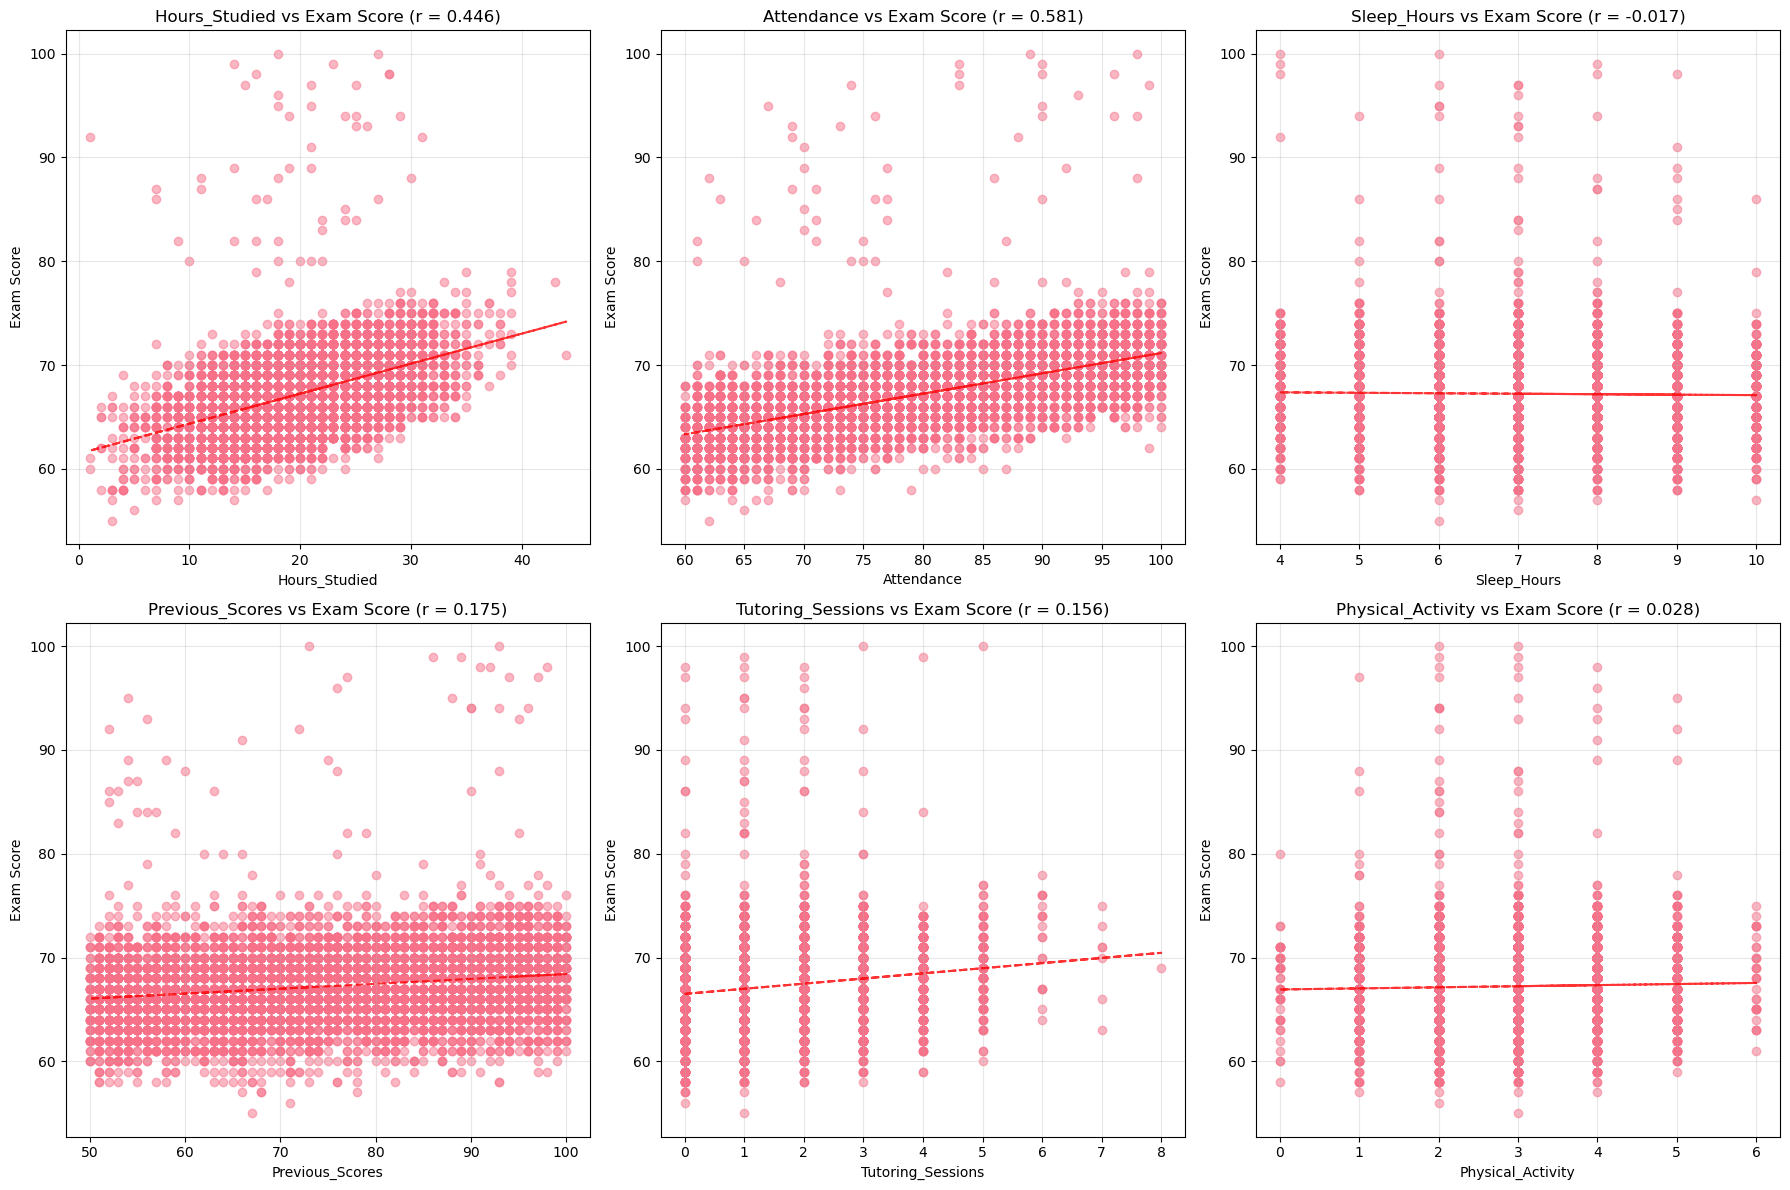

In [110]:
# Visualize key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    axes[i].scatter(df[feature], df['Exam_Score'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Exam Score')
    axes[i].set_title(f'{feature} vs Exam Score (r = {correlation_matrix.loc[feature, "Exam_Score"]:.3f})')
    axes[i].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df[feature], df['Exam_Score'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feature], p(df[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()


Average Exam Score by Motivation_Level:
  High: 67.70
  Medium: 67.33
  Low: 66.75

Average Exam Score by Extracurricular_Activities:
  Yes: 67.44
  No: 66.93

Average Exam Score by Parental_Involvement:
  High: 68.09
  Medium: 67.10
  Low: 66.36

Average Exam Score by School_Type:
  Private: 67.29
  Public: 67.21


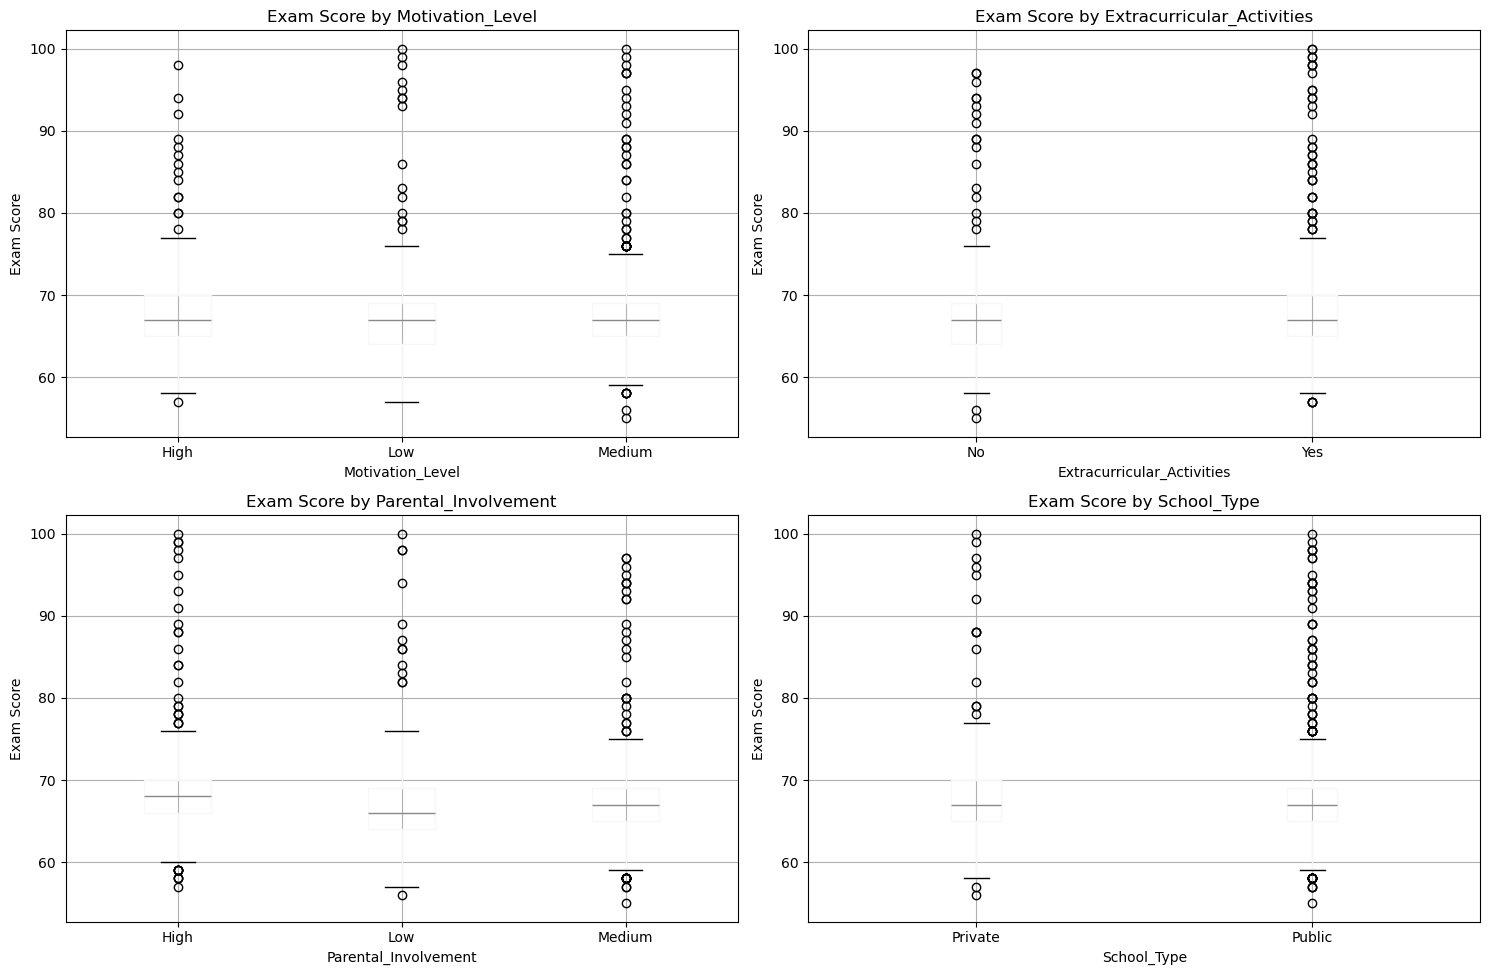

In [111]:
# Analyze categorical features impact
key_categorical = ['Motivation_Level', 'Extracurricular_Activities', 'Parental_Involvement', 'School_Type']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_categorical):
    if feature in df.columns:
        # Box plot for each category
        df.boxplot(column='Exam_Score', by=feature, ax=axes[i])
        axes[i].set_title(f'Exam Score by {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Exam Score')
        
        # Print average scores per category
        avg_scores = df.groupby(feature)['Exam_Score'].mean().sort_values(ascending=False)
        print(f"\nAverage Exam Score by {feature}:")
        for category, score in avg_scores.items():
            print(f"  {category}: {score:.2f}")

plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.show()

## 4. Feature Engineering and Preprocessing Pipeline

In [112]:
# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target distribution - Train mean: {y_train.mean():.2f}, Test mean: {y_test.mean():.2f}")

Training set shape: (5285, 19)
Test set shape: (1322, 19)
Target distribution - Train mean: 67.21, Test mean: 67.32


In [113]:
# Create preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print(f"Numeric features to be scaled: {len(numeric_features)}")
print(f"Categorical features to be encoded: {len(categorical_features)}")

Numeric features to be scaled: 6
Categorical features to be encoded: 13


## 5. Baseline Model: Linear Regression

In [114]:
# Create linear regression pipeline
linear_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
linear_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_pipeline.predict(X_test)

print("Linear Regression model trained successfully")

Linear Regression model trained successfully


In [115]:
# Evaluate linear regression
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Calculate RMSE manually
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE:  {mae:.3f}")
    print(f"R²:   {r2:.3f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate linear model
linear_metrics = evaluate_model(y_test, y_pred_linear, "Linear Regression")


Linear Regression Performance:
RMSE: 1.804
MAE:  0.452
R²:   0.770


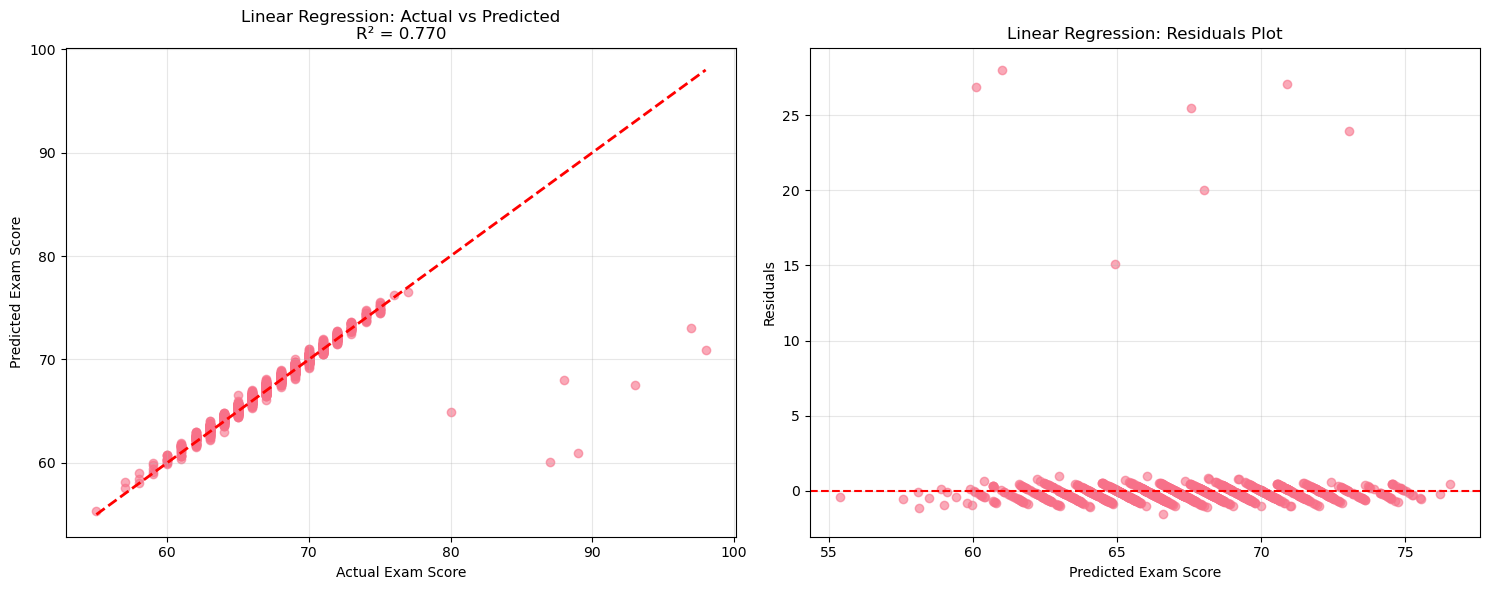

Residuals - Mean: -0.049, Std: 1.804


In [116]:
# Visualize linear regression results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual vs Predicted scatter plot
axes[0].scatter(y_test, y_pred_linear, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Exam Score')
axes[0].set_ylabel('Predicted Exam Score')
axes[0].set_title(f'Linear Regression: Actual vs Predicted\nR² = {linear_metrics["R2"]:.3f}')
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_linear
axes[1].scatter(y_pred_linear, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Exam Score')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Linear Regression: Residuals Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residuals - Mean: {residuals.mean():.3f}, Std: {residuals.std():.3f}")

## 6. Extended Model: Polynomial Regression (Bonus)

In [117]:
# Create polynomial preprocessing for numeric features only
numeric_poly_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Updated preprocessor with polynomial features
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_poly_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create polynomial regression pipeline
poly_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_poly),
    ('regressor', LinearRegression())
])

print(f"Polynomial features (degree 2) will be created for {len(numeric_features)} numeric features")

Polynomial features (degree 2) will be created for 6 numeric features


In [118]:
# Train polynomial regression
poly_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_pipeline.predict(X_test)

# Evaluate polynomial model
poly_metrics = evaluate_model(y_test, y_pred_poly, "Polynomial Regression (degree 2)")

print("\nPolynomial regression trained successfully")


Polynomial Regression (degree 2) Performance:
RMSE: 1.811
MAE:  0.469
R²:   0.768

Polynomial regression trained successfully


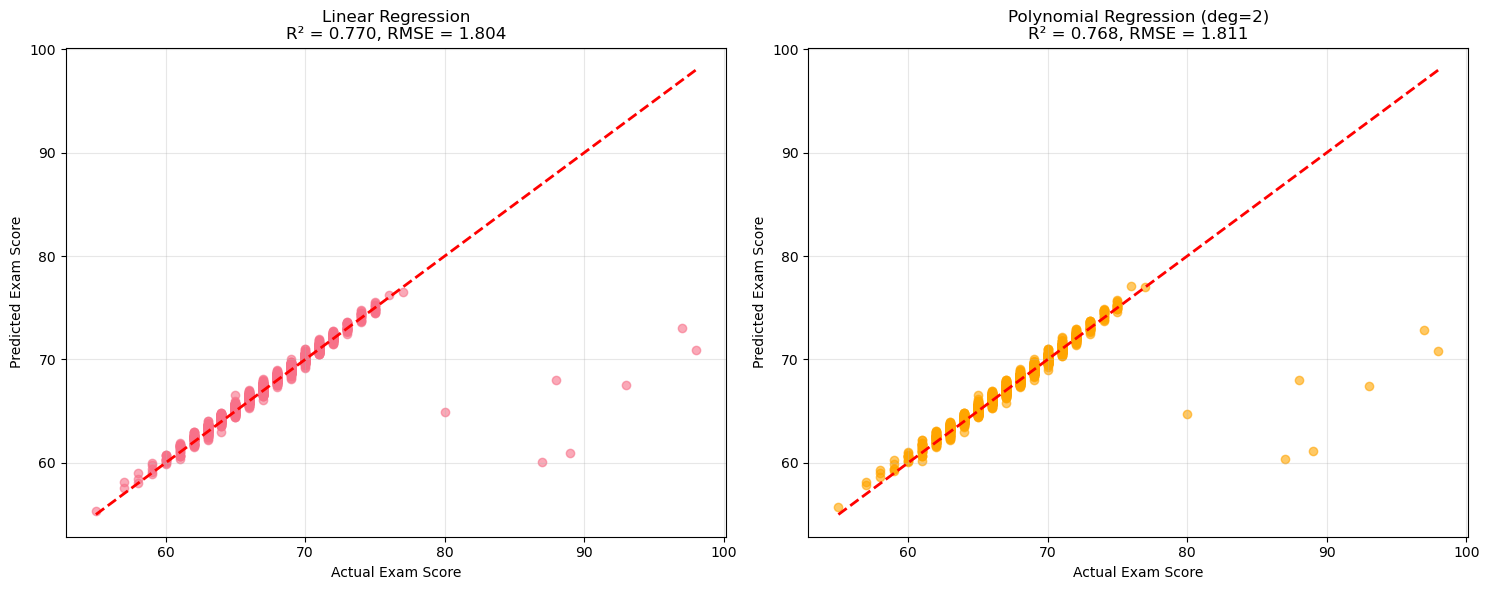

In [119]:
# Compare linear vs polynomial regression
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear regression plot
axes[0].scatter(y_test, y_pred_linear, alpha=0.6, label='Linear')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Exam Score')
axes[0].set_ylabel('Predicted Exam Score')
axes[0].set_title(f'Linear Regression\nR² = {linear_metrics["R2"]:.3f}, RMSE = {linear_metrics["RMSE"]:.3f}')
axes[0].grid(True, alpha=0.3)

# Polynomial regression plot
axes[1].scatter(y_test, y_pred_poly, alpha=0.6, label='Polynomial', color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Exam Score')
axes[1].set_ylabel('Predicted Exam Score')
axes[1].set_title(f'Polynomial Regression (deg=2)\nR² = {poly_metrics["R2"]:.3f}, RMSE = {poly_metrics["RMSE"]:.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Combination Experiments

In [120]:
# Define features to experiment with
experiment_features = {
    'Sleep_Hours': 'Sleep_Hours',
    'Motivation_Level': 'Motivation_Level', 
    'Extracurricular_Activities': 'Extracurricular_Activities'
}

# Function to test feature combinations
def test_feature_combination(features_to_remove, experiment_name):
    """Test model performance with specific features removed"""
    
    # Create feature lists without removed features
    numeric_features_exp = [f for f in numeric_features if f not in features_to_remove]
    categorical_features_exp = [f for f in categorical_features if f not in features_to_remove]
    
    # Create new preprocessor
    preprocessor_exp = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_exp),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_exp)
        ]
    )
    
    # Create and train pipeline
    pipeline_exp = Pipeline(steps=[
        ('preprocess', preprocessor_exp),
        ('regressor', LinearRegression())
    ])
    
    # Fit and predict
    pipeline_exp.fit(X_train, y_train)
    y_pred_exp = pipeline_exp.predict(X_test)
    
    # Calculate metrics
    metrics_exp = evaluate_model(y_test, y_pred_exp, experiment_name)
    
    return metrics_exp



In [121]:
# Experiment results storage
experiment_results = {}

# Baseline (all features)
experiment_results['All Features'] = linear_metrics

# Individual feature removal experiments
for feature_name, feature_col in experiment_features.items():
    if feature_col in X.columns:
        metrics = test_feature_combination([feature_col], f"Without {feature_name}")
        experiment_results[f'Without {feature_name}'] = metrics

# Remove all three experimental features
all_exp_features = [f for f in experiment_features.values() if f in X.columns]
if all_exp_features:
    metrics = test_feature_combination(all_exp_features, "Without Sleep, Motivation & Extracurricular")
    experiment_results['Without Sleep, Motivation & Extracurricular'] = metrics

print("Feature combination experiments completed")


Without Sleep_Hours Performance:
RMSE: 1.804
MAE:  0.451
R²:   0.770

Without Motivation_Level Performance:
RMSE: 1.847
MAE:  0.561
R²:   0.759

Without Extracurricular_Activities Performance:
RMSE: 1.818
MAE:  0.503
R²:   0.766

Without Sleep, Motivation & Extracurricular Performance:
RMSE: 1.861
MAE:  0.599
R²:   0.755
Feature combination experiments completed



Feature Combination Experiment Results:
                                              RMSE    MAE     R2  R2_Diff
All Features                                 1.804  0.452  0.770   0.0003
Without Sleep_Hours                          1.804  0.451  0.770   0.0003
Without Extracurricular_Activities           1.818  0.503  0.766  -0.0037
Without Motivation_Level                     1.847  0.561  0.759  -0.0107
Without Sleep, Motivation & Extracurricular  1.861  0.599  0.755  -0.0147


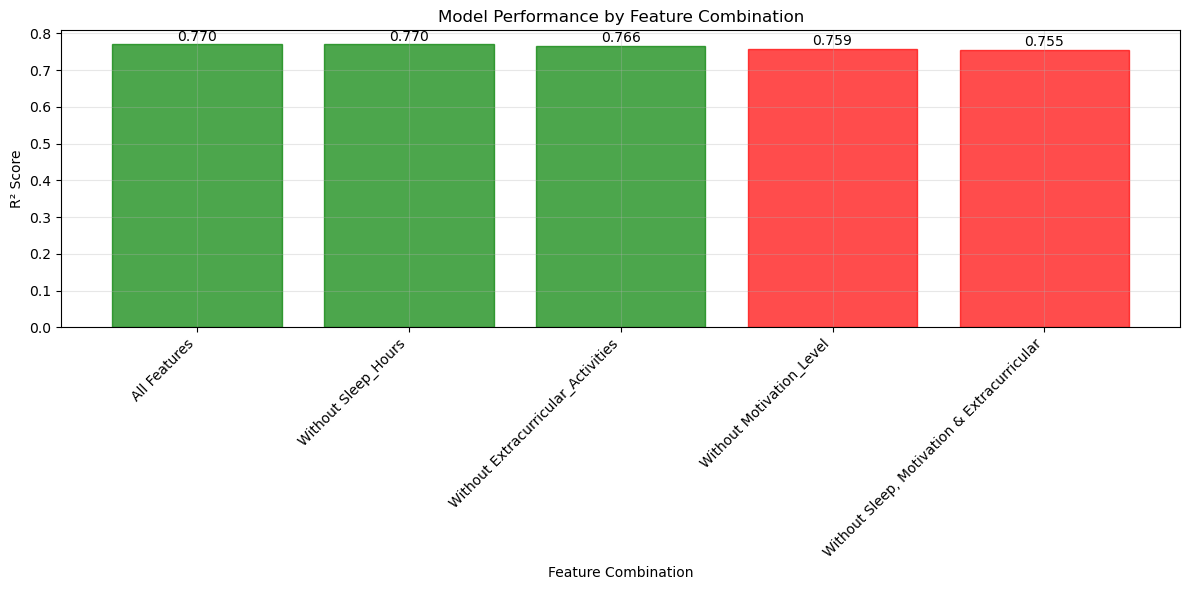

In [122]:
# Create comparison table
import pandas as pd

results_df = pd.DataFrame(experiment_results).T
results_df = results_df.round(3)

# Add difference from baseline
baseline_r2 = experiment_results['All Features']['R2']
results_df['R2_Diff'] = (results_df['R2'] - baseline_r2).round(4)

# Sort by R2 score
results_df = results_df.sort_values('R2', ascending=False)

print("\nFeature Combination Experiment Results:")
print("=" * 60)
print(results_df)

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = range(len(results_df))
bars = ax.bar(x_pos, results_df['R2'], alpha=0.7)

# Color bars based on performance
colors = ['green' if diff >= -0.005 else 'orange' if diff >= -0.01 else 'red' 
          for diff in results_df['R2_Diff']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('Feature Combination')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance by Feature Combination')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, r2) in enumerate(zip(bars, results_df['R2'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{r2:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Model Comparison and Final Results


Final Model Comparison:
                                   RMSE    MAE     R2
Linear Regression (All Features)  1.804  0.452  0.770
Polynomial Regression (Degree 2)  1.811  0.469  0.768


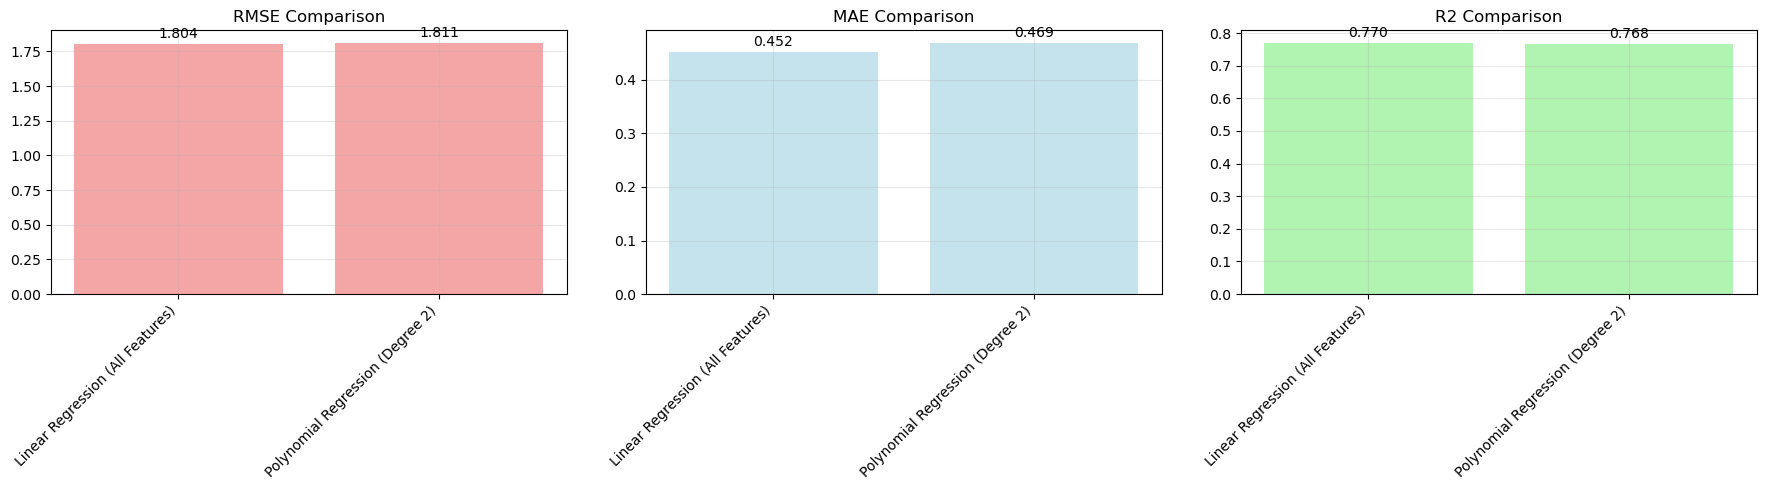

In [123]:
# Final model comparison
final_comparison = {
    'Linear Regression (All Features)': linear_metrics,
    'Polynomial Regression (Degree 2)': poly_metrics
}

# Find best feature combination (highest R2)
best_feature_combo = results_df.index[0]
best_metrics = results_df.iloc[0].to_dict()
final_comparison[f'Linear Regression ({best_feature_combo})'] = {
    'RMSE': best_metrics['RMSE'], 
    'MAE': best_metrics['MAE'], 
    'R2': best_metrics['R2']
}

final_df = pd.DataFrame(final_comparison).T.round(3)

print("\nFinal Model Comparison:")
print("=" * 50)
print(final_df)

# Visualize final comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['RMSE', 'MAE', 'R2']
colors = ['lightcoral', 'lightblue', 'lightgreen']

for i, metric in enumerate(metrics):
    values = final_df[metric]
    bars = axes[i].bar(range(len(values)), values, color=colors[i], alpha=0.7)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xticks(range(len(values)))
    axes[i].set_xticklabels(final_df.index, rotation=45, ha='right')
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()